In [16]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from typing import Dict, Tuple, List
from utils import dref_dataframe, dump_dref
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")


def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    # out = out.reshape(((huge_pages + 31) // 32, 32))
    return pd.DataFrame(out)

def load_data(max_mem: int, modes: Dict[str, Path]) -> Tuple[pd.DataFrame, List[Dict[str, int]]]:
    datas = []
    for mode, p in modes.items():
        data = pd.read_csv(p / "out_0.csv")
        data["mode"] = mode
        datas.append(data)

    data = pd.concat(datas)
    data.loc[data["total"].isnull(), "total"] = max_mem
    data["small"] = data["total"] - data["small"] * 2**12
    data["huge"] = data["total"] - data["huge"] * 2**(12+9)
    data["time"] = data.index
    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["rss", "small", "huge", "cached"])

    times = [json.load((p / "times_0.json").open()) for p in modes.values()]
    for t in times:
        if "shrink" in t:
            t["drop"] = t["shrink"]
        if not isinstance(t["build"], list):
            t["build"] = [t["build"]]
        if not isinstance(t["delay"], list):
            t["delay"] = [t["delay"]]
    return data, times

def y_at(data: pd.DataFrame, x: int):
    # TODO: Change to rss
    return data[data["measurement"] == "huge"][(data["time"] - x).abs() < 2]["bytes"].max()

def relplot(max_mem: int, data: pd.DataFrame, times: List[Dict[str, int]]) -> Tuple[sns.FacetGrid, Dict[str, int]]:
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", hue="measurement", height=5.5, legend=False)
    p.set_titles("{col_name}")
    p.set(ylabel="Memory consumption [GiB]")
    p.set(xlabel="Time [seconds]")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])

    modes = data["mode"].unique()
    extra_keys = {}

    h = list(p.axes[0][0].get_lines())
    l = list(data["measurement"].unique())
    p.add_legend(handles=h, labels=l, loc="upper center", bbox_to_anchor=(0.31, 0.04), ncol=7, frameon=True)

    p.refline(y=max_mem, color=sns.crayons["Gray"])
    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]


        tlast = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time["build"], time["delay"]):
            axis.axvspan(
                xmin=tlast, xmax=tbuild, ymax=0.91, edgecolor=sns.crayons["Gray"],
                facecolor="white", zorder=-1, hatch="//")

            b_mid = tlast + (tbuild - tlast)/2
            axis.text(b_mid, max_mem * 1.02, "runtime", horizontalalignment="center",
                        path_effects=[patheffects.withStroke(linewidth=5, foreground='white')])

            gib_m = celld[(tlast <= celld["time"])
                & (celld["time"] < tbuild)
                & (celld["measurement"] == "huge")]["bytes"].sum() / 1024**3 / 60 # TODO: RSS!
            print(f"{modes[i]}: {gib_m:.2f} GiB*m, {tbuild - tlast} s")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tlast

            gib = y_at(celld, tbuild + (tdelay - tbuild)/2) / 1024**3
            prefix += f"delay {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/{j}/delay/gib"] = gib
            tlast = tdelay
            j += 1

        tdelay = time["delay"][-1] if isinstance(time["delay"], list) else time["delay"]
        if "clean" in time and time["clean"]:
            axis.annotate(
                "clean",
                (tdelay, y_at(celld, tdelay) + max_mem/32),
                (tdelay, max_mem * 0.925),
                horizontalalignment="center",
                path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
                arrowprops={"facecolor": sns.crayons["Violet (Purple)"]})
            tdelay = time["clean"]
            gib = y_at(celld, tdelay) / 1024**3
            prefix += f"clean {gib:.2f} GiB, "
            extra_keys[f"{modes[i]}/clean/gib"] = gib

        axis.annotate(
            "drop",
            (tdelay, y_at(celld, tdelay) + max_mem/32),
            (tdelay, max_mem * 0.85),
            horizontalalignment="center",
            path_effects=[patheffects.withStroke(linewidth=5, foreground='white')],
            arrowprops={"facecolor": "black"})
        gib = y_at(celld, time["drop"]) / 1024**3
        prefix += f"drop {gib:.2f} GiB, "
        extra_keys[f"{modes[i]}/drop/gib"] = gib

        gib_m = celld[celld["measurement"] == "huge"]["bytes"].sum() / 1024**3 / 60 # TODO: RSS!
        prefix += f"{gib_m:.2f} GiB*m"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m

        print(f"{modes[i]}: {prefix}")

    return p, extra_keys


def visualize(max_mem: int, modes: Dict[str, Path], save_as: str | None = None) -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(max_mem, data, times)
    if save_as:
        p.savefig(Path("compiling") / f"{save_as}.pdf")
        p.savefig(Path("compiling") / f"{save_as}.svg")
        dref_dataframe(save_as, Path("compiling"), ["mode", "measurement", "time"], data)
        with (Path("compiling") / f"{save_as}_extra.dref").open("w+") as f:
            dump_dref(f, save_as, extra_keys)
    return p


## Linux

Baseline: 4.35 GiB*m, 138 s
Baseline: delay 2.17 GiB, clean 2.04 GiB, drop 1.76 GiB, 8.07 GiB*m
HyperAlloc: 5.39 GiB*m, 136 s
HyperAlloc: delay 2.06 GiB, clean 1.92 GiB, drop 0.87 GiB, 9.69 GiB*m


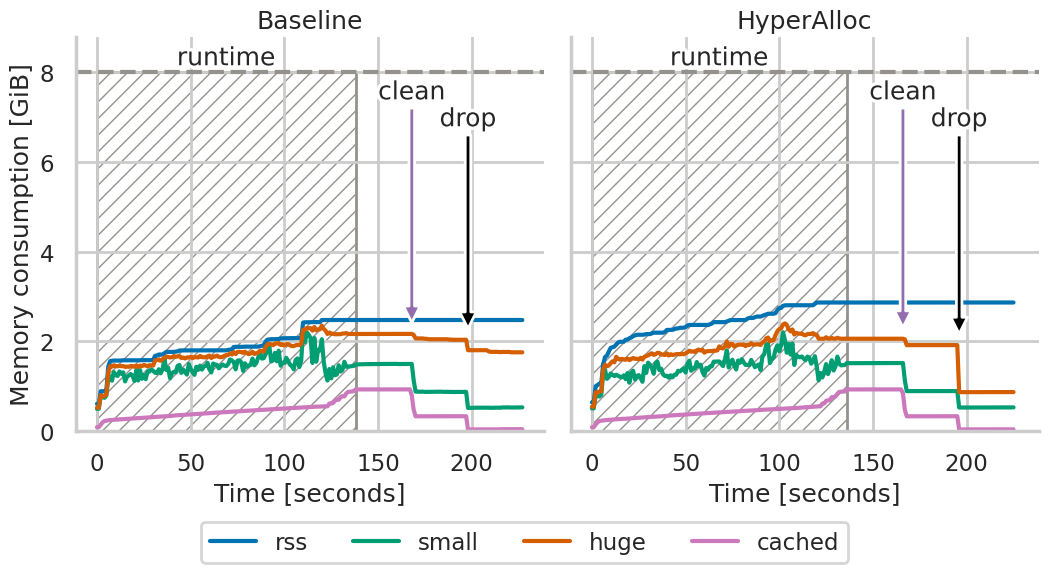

In [11]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "Baseline": Path("compiling/latest-linux-base-manual"),
    "HyperAlloc": Path("compiling/latest-linux-llfree-manual"),
})

virtio-balloon: 4.28 GiB*m, 137 s
virtio-balloon: delay 1.99 GiB, clean 1.96 GiB, drop 1.77 GiB, 7.32 GiB*m
HyperAlloc: 4.54 GiB*m, 136 s
HyperAlloc: delay 2.11 GiB, clean 1.95 GiB, drop 0.87 GiB, 7.21 GiB*m


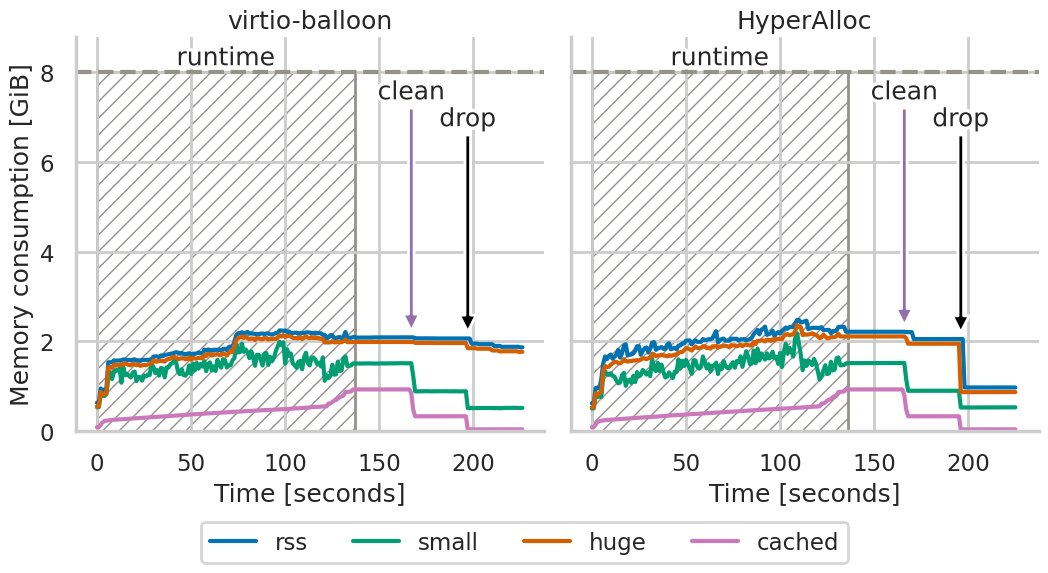

In [12]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-linux-base-auto"),
    "HyperAlloc": Path("compiling/latest-linux-llfree-auto"),
}, "linux-auto")

virtio-balloon-huge: 4.28 GiB*m, 136 s
virtio-balloon-huge: delay 2.04 GiB, clean 2.02 GiB, drop 1.88 GiB, 7.39 GiB*m
HyperAlloc+VFIO: 4.64 GiB*m, 137 s
HyperAlloc+VFIO: delay 2.12 GiB, clean 1.96 GiB, drop 0.89 GiB, 7.36 GiB*m


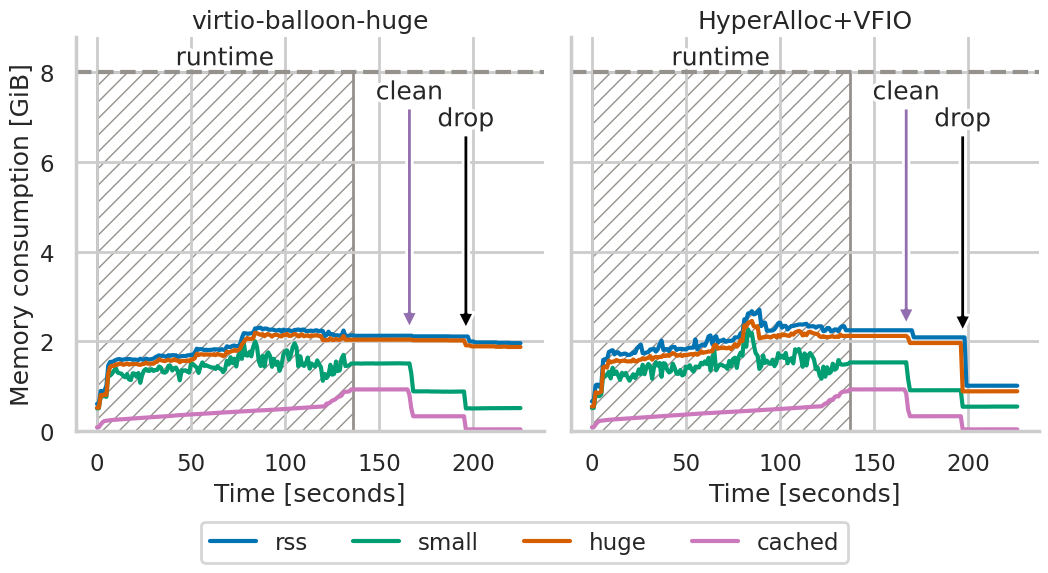

In [13]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "virtio-balloon-huge": Path("compiling/latest-linux-huge-auto"),
    "HyperAlloc+VFIO": Path("compiling/latest-linux-llfree-auto-vfio"),
})

virtio-mem-movable-vfio: 3.68 GiB*m, 134 s
virtio-mem-movable-vfio: delay 1.82 GiB, clean 1.82 GiB, drop 1.75 GiB, 6.38 GiB*m
llfree-auto-vfio: 3.66 GiB*m, 136 s
llfree-auto-vfio: delay 1.86 GiB, clean 1.71 GiB, drop 0.65 GiB, 5.78 GiB*m


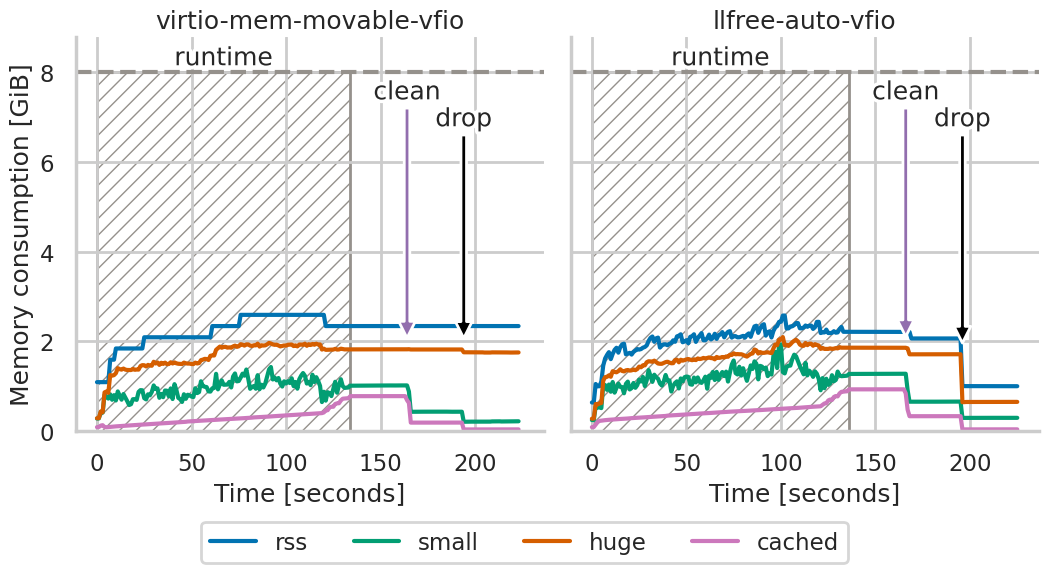

In [12]:
max_mem = 8*1024**3
p = visualize(max_mem, {
    "virtio-mem-movable-vfio": Path("compiling/240807-141023-linux-virtio-mem-vfio"),
    "llfree-auto-vfio": Path("compiling/240807-135016-linux-llfree-auto-vfio"),
})


## Clang

Buddy Baseline: 305.31 GiB*m, 1508 s
Buddy Baseline: delay 12.65 GiB, clean 12.02 GiB, drop 9.05 GiB, 465.76 GiB*m
HyperAlloc Baseline: 306.97 GiB*m, 1478 s
HyperAlloc Baseline: delay 10.66 GiB, clean 7.44 GiB, drop 2.17 GiB, 466.23 GiB*m


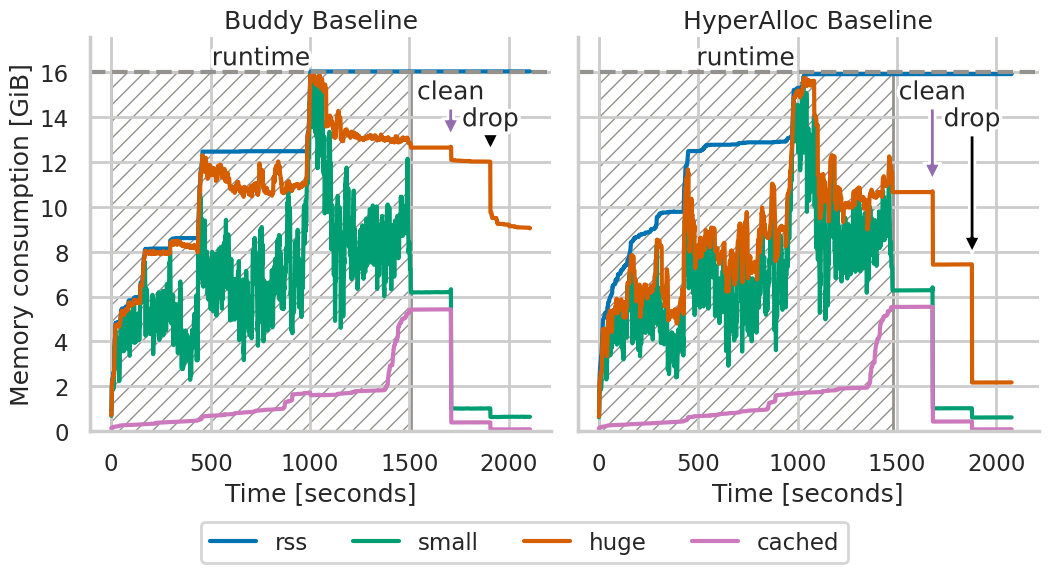

In [14]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "Buddy Baseline": Path("compiling/latest-clang-base-manual"),
    "HyperAlloc Baseline": Path("compiling/latest-clang-llfree-manual"),
}, "clang-baseline")

virtio-balloon: 269.61 GiB*m, 1495 s
virtio-balloon: delay 12.16 GiB, clean 11.46 GiB, drop 8.93 GiB, 380.07 GiB*m
HyperAlloc: 223.70 GiB*m, 1475 s
HyperAlloc: delay 10.85 GiB, clean 7.42 GiB, drop 2.18 GiB, 293.54 GiB*m


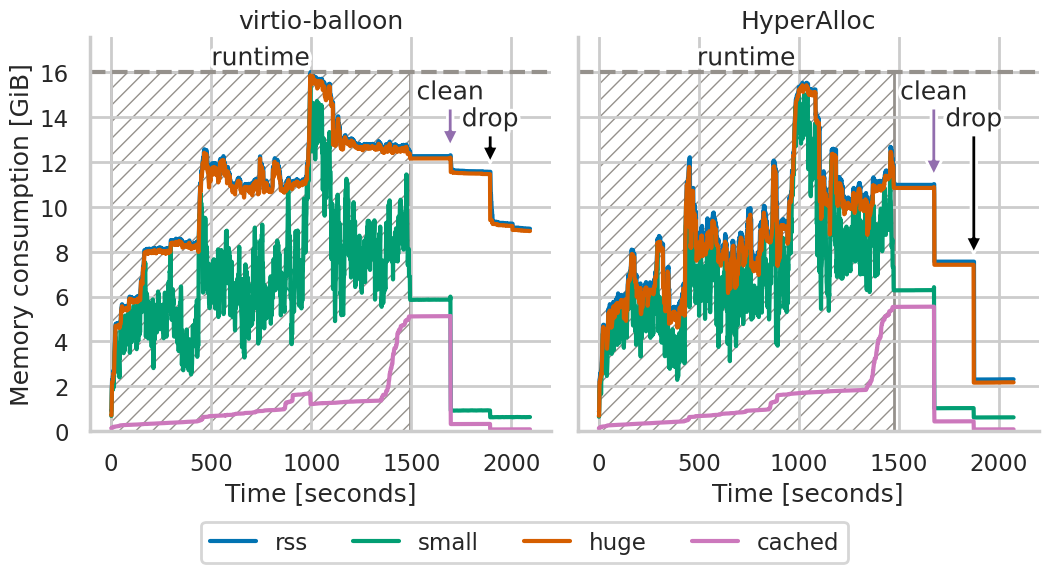

In [15]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "clang-auto")

virtio-balloon-huge: 275.05 GiB*m, 1499 s
virtio-balloon-huge: delay 12.68 GiB, clean 11.88 GiB, drop 9.28 GiB, 389.37 GiB*m
HyperAlloc+VFIO: 226.18 GiB*m, 1478 s
HyperAlloc+VFIO: delay 11.06 GiB, clean 7.25 GiB, drop 2.05 GiB, 296.22 GiB*m


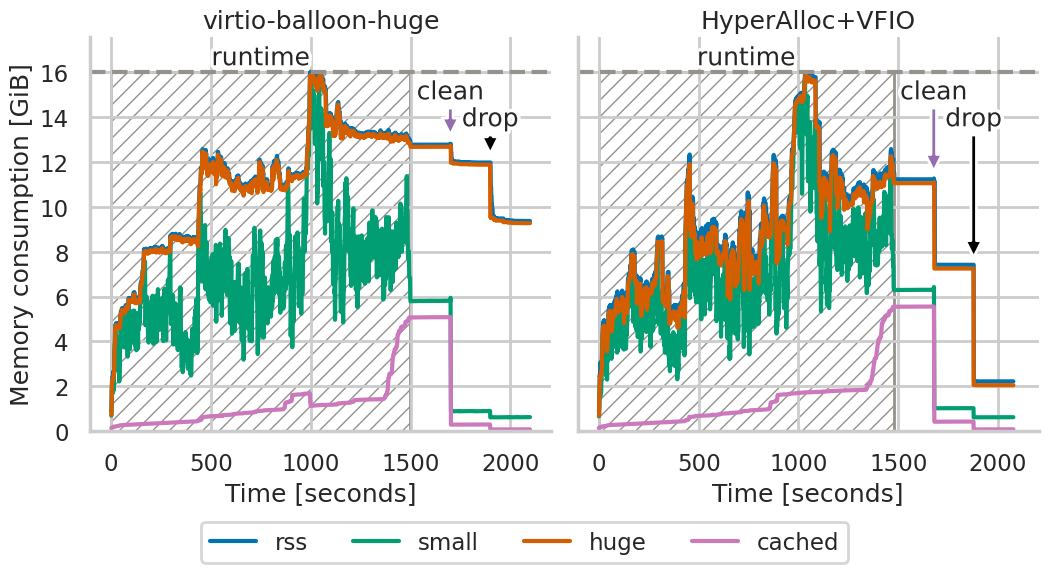

In [16]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon-huge": Path("compiling/latest-clang-huge-auto"),
    "HyperAlloc+VFIO": Path("compiling/latest-clang-llfree-auto-vfio"),
}, "clang-huge-vfio")

virtio-mem+VFIO: 230.99 GiB*m, 1586 s
virtio-mem+VFIO: delay 10.02 GiB, clean 1.47 GiB, drop 0.77 GiB, 275.85 GiB*m
HyperAlloc+VFIO: 218.60 GiB*m, 1478 s
HyperAlloc+VFIO: delay 11.06 GiB, clean 7.25 GiB, drop 2.05 GiB, 286.65 GiB*m


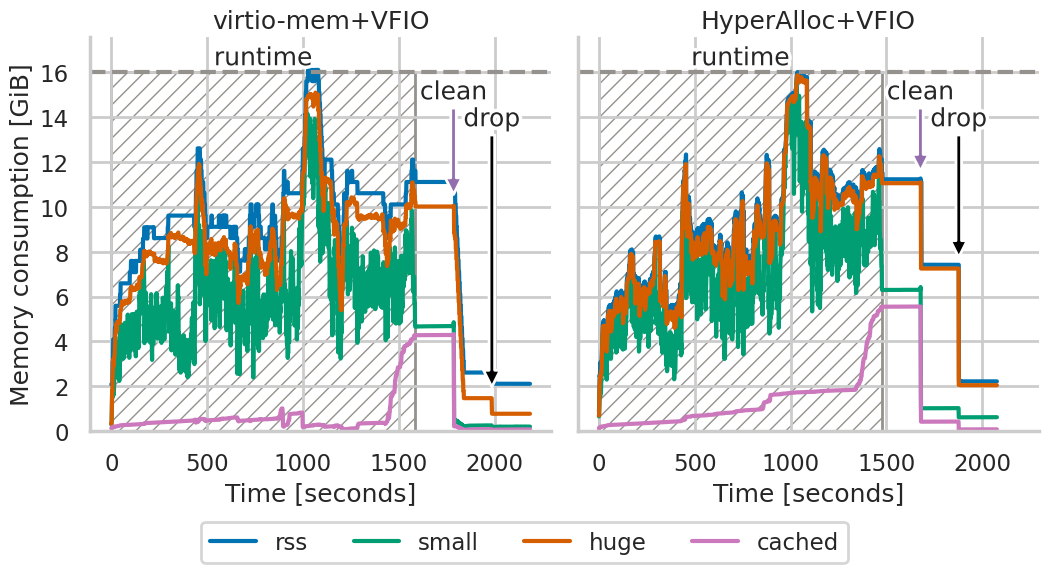

In [17]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-mem+VFIO": Path("compiling/240807-142400-clang-virtio-mem-vfio"),
    "HyperAlloc+VFIO": Path("compiling/latest-clang-llfree-auto-vfio"),
})

## SPEC17 Blender

virtio-balloon: 41.74 GiB*m, 328 s
virtio-balloon: 42.56 GiB*m, 328 s
virtio-balloon: 43.03 GiB*m, 328 s
virtio-balloon: delay 3.16 GiB, delay 5.00 GiB, delay 5.70 GiB, drop 4.27 GiB, 202.28 GiB*m
HyperAlloc: 41.75 GiB*m, 328 s
HyperAlloc: 42.06 GiB*m, 326 s
HyperAlloc: 42.51 GiB*m, 329 s
HyperAlloc: delay 1.74 GiB, delay 2.13 GiB, delay 2.50 GiB, drop 1.16 GiB, 158.69 GiB*m


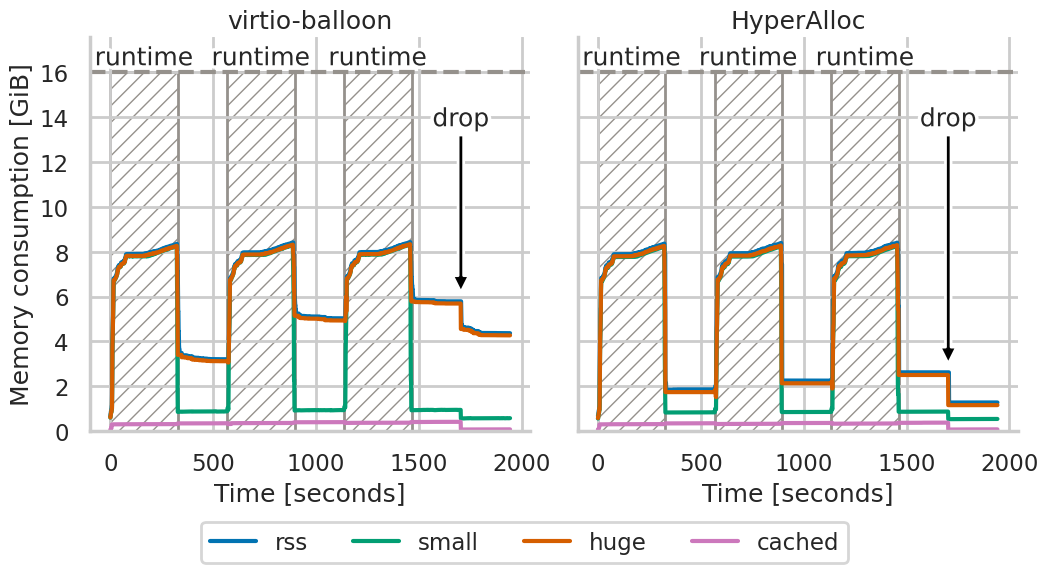

In [17]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "virtio-balloon": Path("compiling/latest-blender-base-auto"),
    "HyperAlloc": Path("compiling/latest-blender-llfree-auto"),
}, "blender-auto")

# Testing

In [3]:
from matplotlib import colors
import matplotlib.pyplot as plt

def cscale(rgba: Tuple[float, float, float, float], m: float) -> Tuple[float, float, float, float]:
    return (rgba[0] * m, rgba[1] * m, rgba[2] * m, rgba[3])

def cmap_extreme(map: colors.Colormap, min=0, max=1) -> colors.Colormap:
    class Wrap(colors.Colormap):
        def __init__(self, cmap: colors.Colormap):
            self.cmap = cmap
        def __getattr__(self, name):
            if name == "cmap": return self.cmap
            return getattr(self.cmap, name)
        def __eq__(self, other):
            self.cmap.__eq__(other)
        def __copy__(self):
            Wrap(self.cmap.__copy__())
        def __call__(self, X, alpha=None, bytes=False):
            if isinstance(X, np.ndarray):
                X = X - (X <= min) + (X >= max)
            if isinstance(X, float) or isinstance(X, int):
                if X <= min:
                    return self.cmap(X - 1.0, alpha, bytes)
                if X >= max:
                    return self.cmap(X + 1.0, alpha, bytes)
            return self.cmap(X, alpha, bytes)

    return Wrap(map.with_extremes(
        under=cscale(map(-1.0), 0.5), over=cscale(map(2.0), 0.5)))

LLFree 16M: 210.64 GiB*m, 1261 s
LLFree 16M: delay 11.83 GiB, clean 8.84 GiB, drop 2.29 GiB, 287.26 GiB*m
LLFree 128M: 210.77 GiB*m, 1262 s
LLFree 128M: delay 12.24 GiB, clean 10.28 GiB, drop 3.23 GiB, 296.60 GiB*m
LLFree 1G: 245.80 GiB*m, 1260 s
LLFree 1G: delay 12.93 GiB, clean 11.10 GiB, drop 6.83 GiB, 348.62 GiB*m


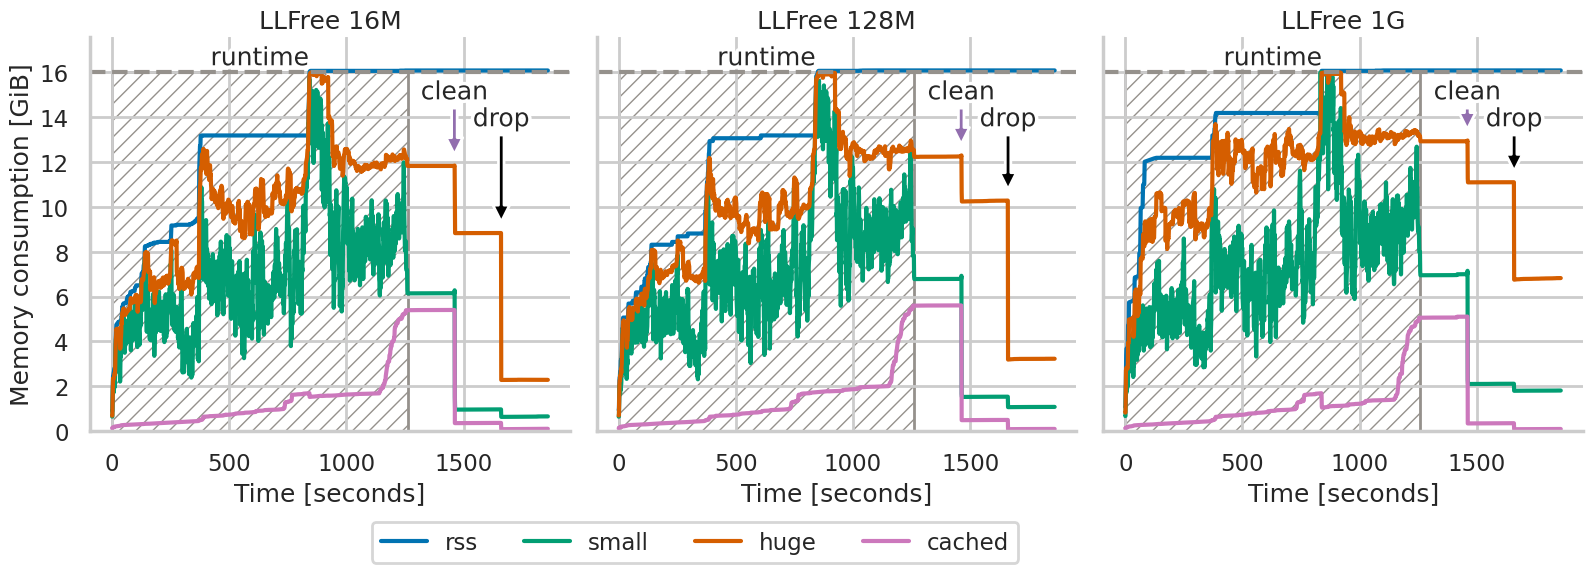

In [11]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "LLFree 16M": Path("compiling/240603-234305-clang-llfree-test"),
    "LLFree 128M": Path("compiling/240603-153327-clang-llfree-test"),
    "LLFree 1G": Path("compiling/240604-175853-clang-llfree-test"),
})

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]


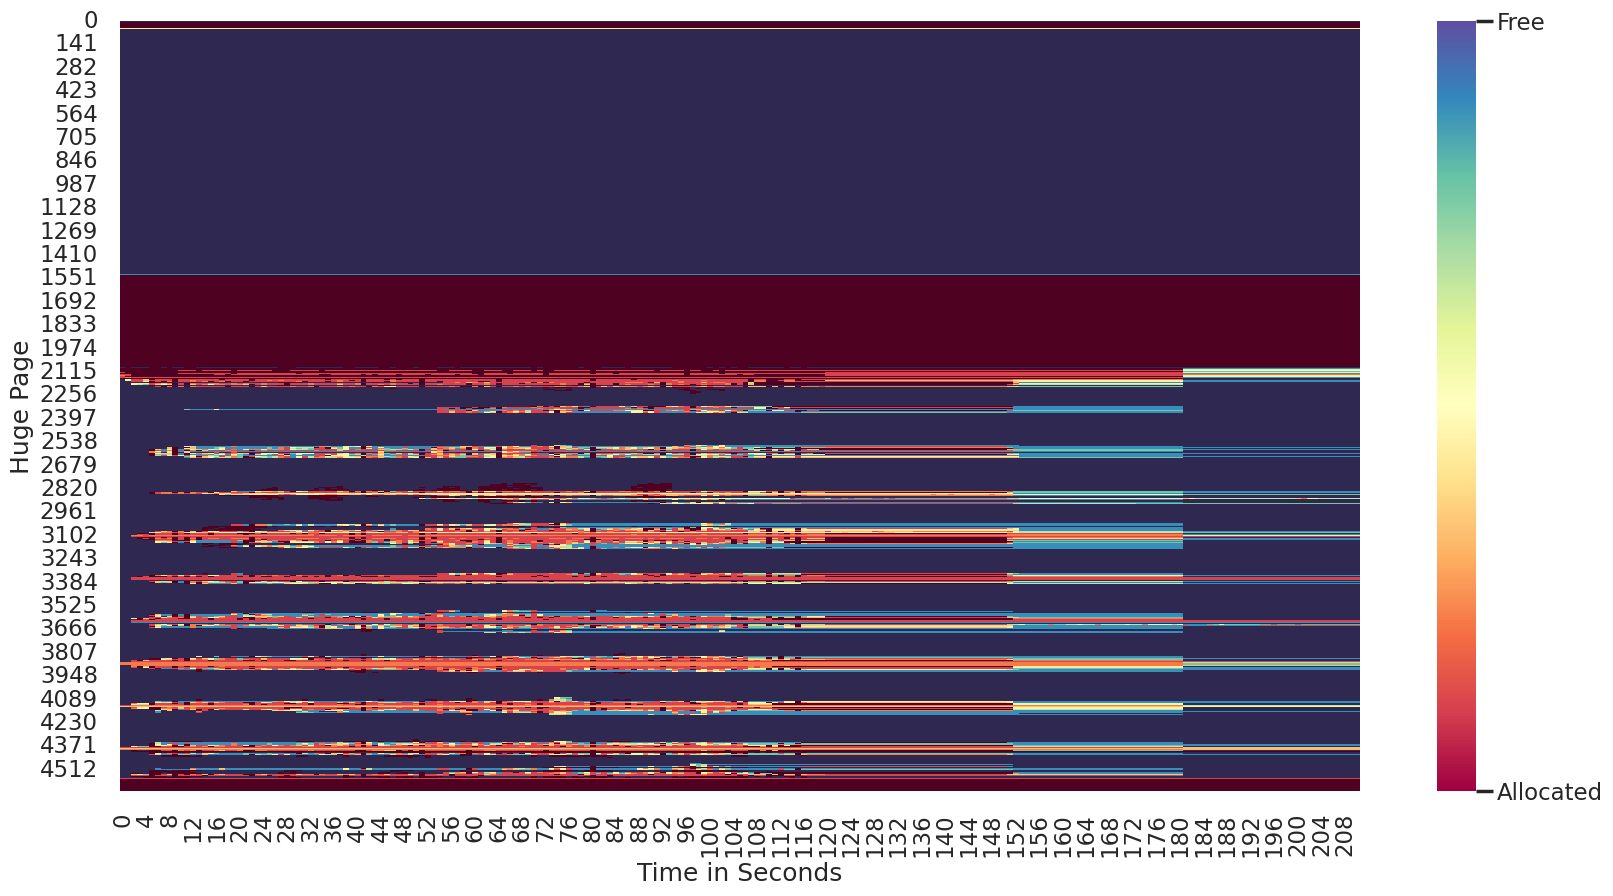

In [9]:
root = Path("compiling/240530-171416-linux-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]


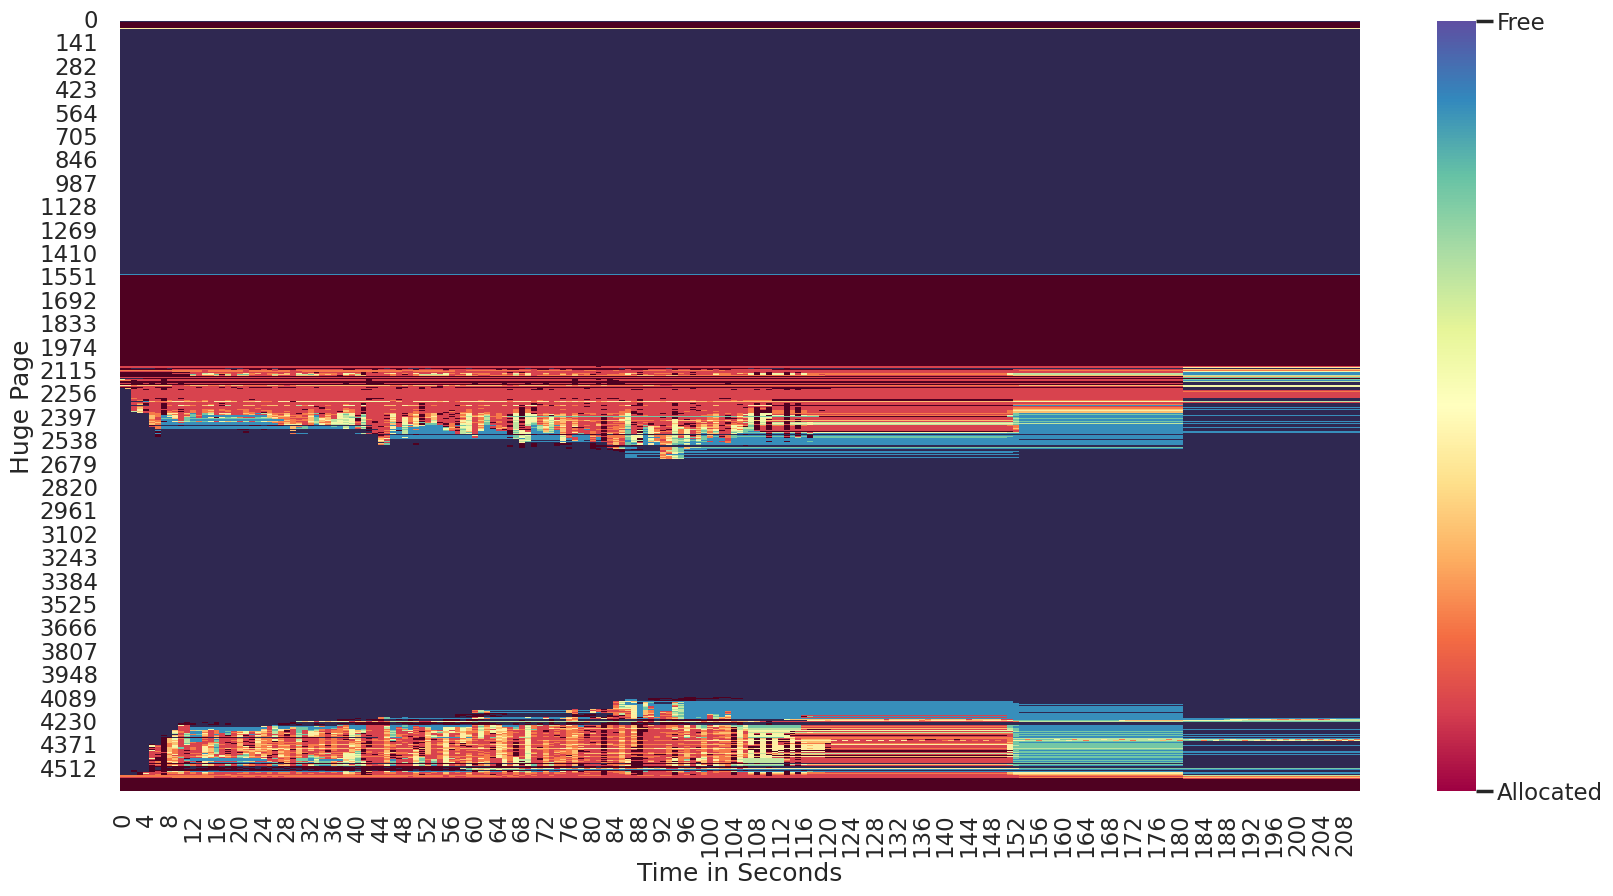

In [11]:
root = Path("compiling/240530-173108-linux-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

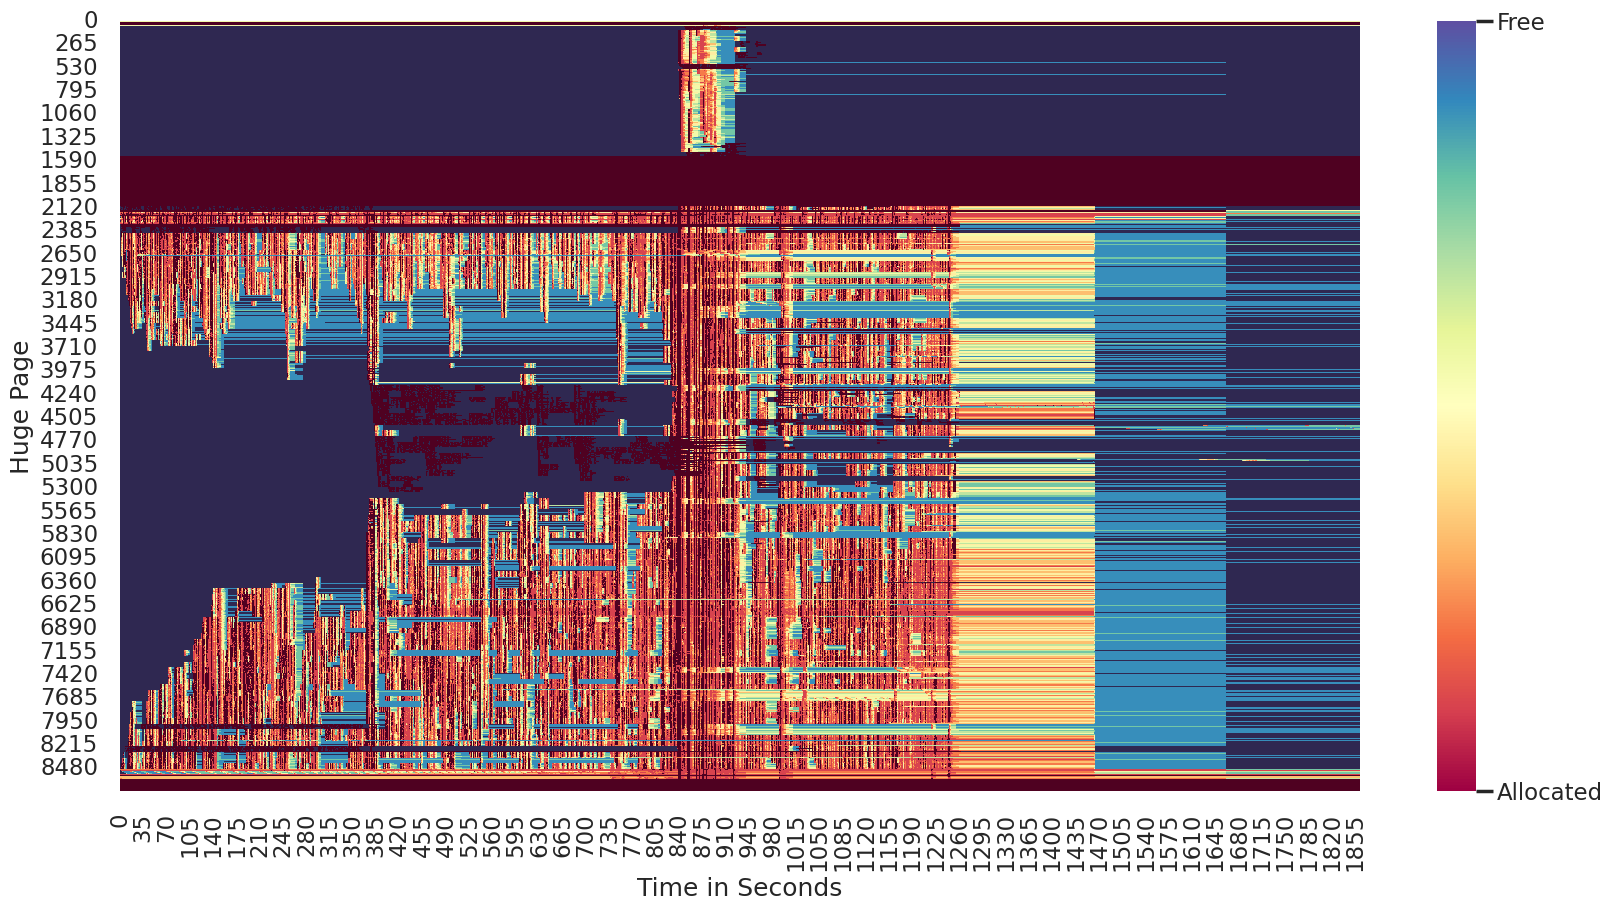

In [4]:
root = Path("compiling/240603-153327-clang-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

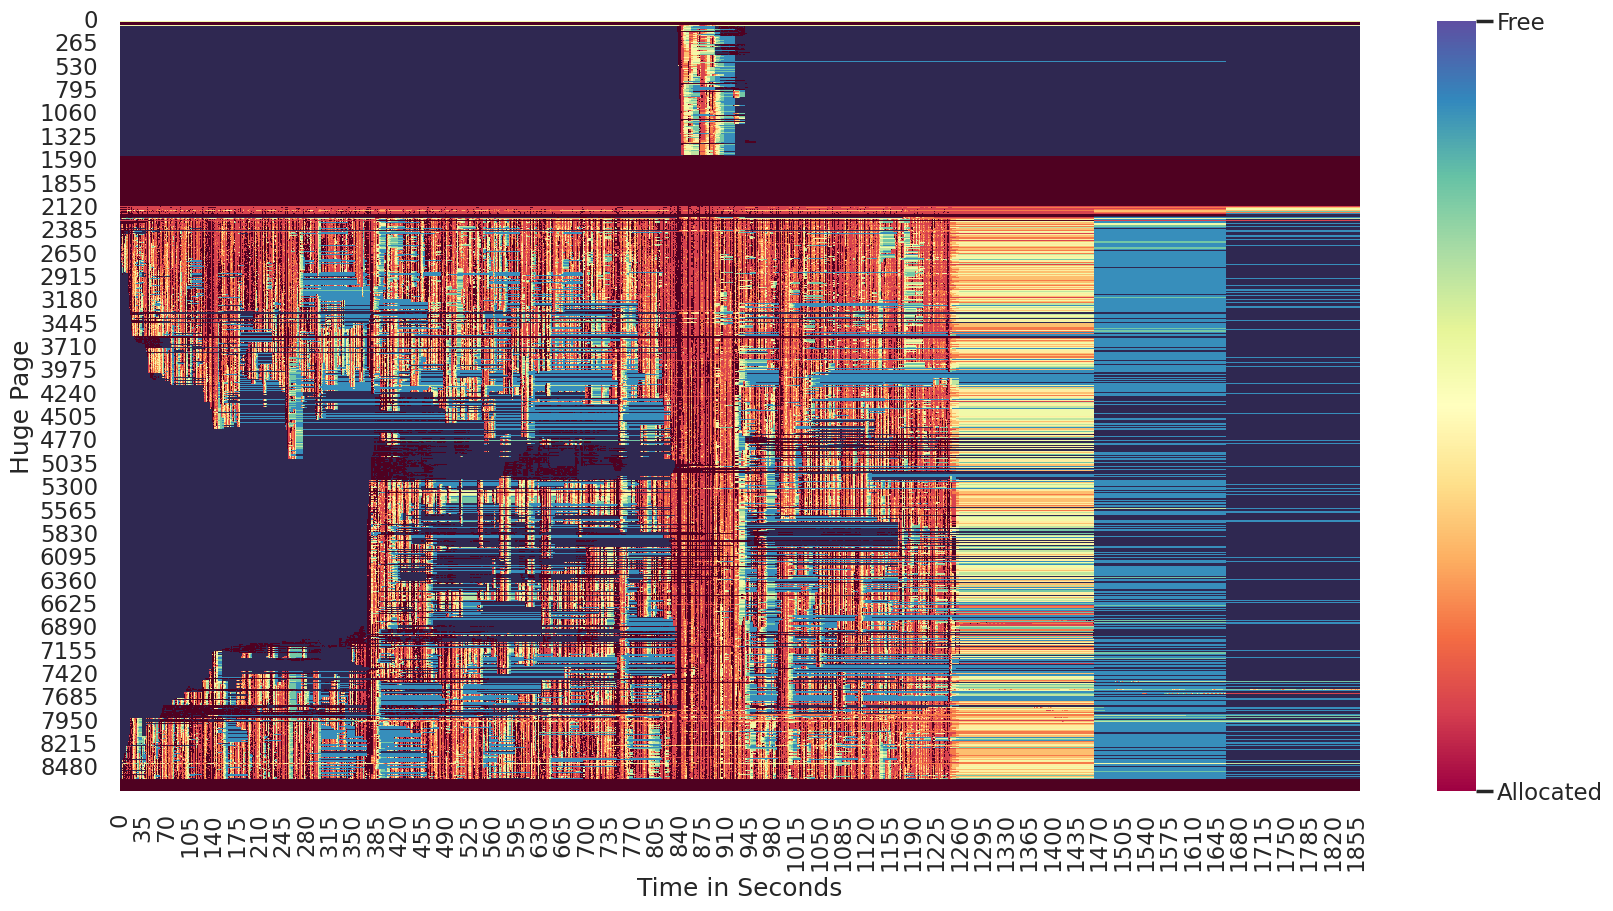

In [4]:
root = Path("compiling/240603-234305-clang-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

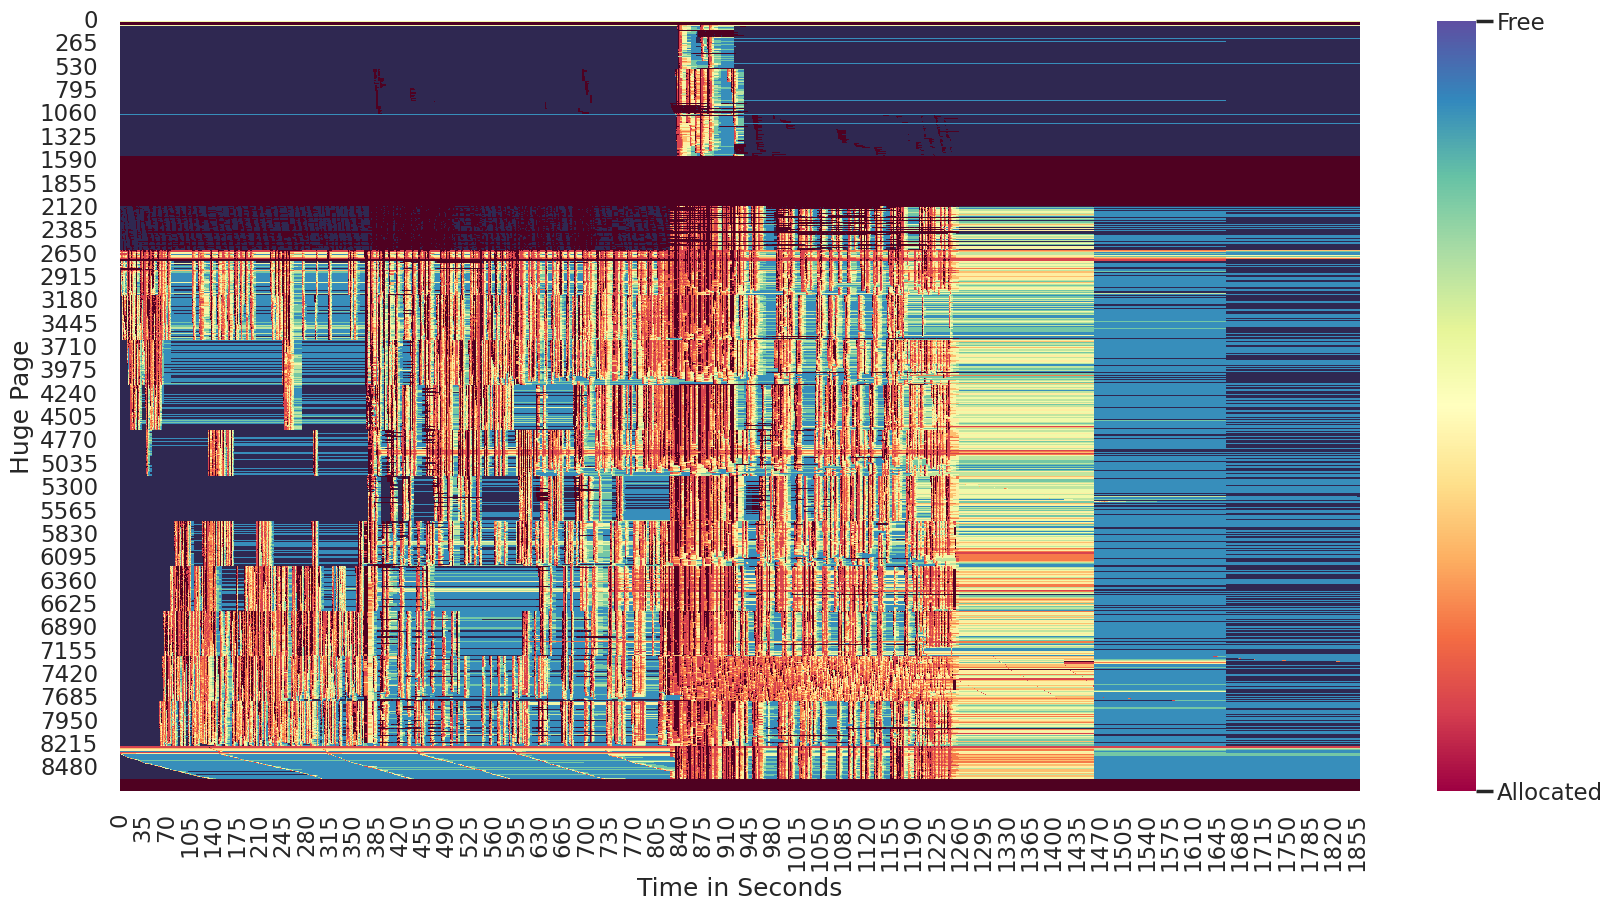

In [8]:
root = Path("compiling/240604-175853-clang-llfree-test")

cmap = cmap_extreme(sns.color_palette("Spectral", as_cmap=True, n_colors=10))

data = {}
for file in root.glob("frag_0_*.txt"):
    try:
        i = int(file.stem[7:])
        data[i] = parse_frag(file)
    except Exception:
        pass
print(sorted(data.keys()))

frames = []
for i, frame in sorted(list(data.items()), key=lambda x: x[0]):
    frames.append(frame)
data = pd.concat(frames, axis=1, ignore_index=True)
data *= 512 / 9

fix, ax = plt.subplots()
fix.set_figwidth(20)
fix.set_figheight(10)
fix.set_figheight(10)
fix.set_facecolor("white")
p = sns.heatmap(data, ax=ax, cmap=cmap)
p.set_xlabel("Time in Seconds")
p.set_ylabel("Huge Page")

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, 512])
colorbar.set_ticklabels(["Allocated", "Free"])